# Question 2

## Model Architecture

### Encoder
* 2d Convolution layer x 3
  - filters: 64
  - kernel: 4*4
  - strides: (2,2)
  - activation: leaked relu
* Three 2d convolutional layers are stacked up with same configurations.
* Dropout: 0.2
* Mean, Standard Deviation are calculated with the cnn output.
* Using $mu$, $sd$ $z$ is constructed with equation 
$$ z = mu + {epsilon}*sd $$

### Decoder
* 2d Convolutional Transpose layer x 3
  - filters: 64
  - kernel: 4*4
  - strides: (2*2)
  - activation: relu
* 3 convolutional transpose layers are stacked up similar to encoder.
* Sigmoid activation is applied before taking the output.


## Training
* Batch Size: 64
* Learning rate: $5e-4$
* Epochs: 20

### Observation
* I have taken $K=4$, as number of diesions in latent space.
* After training the VAE for 20 epochs, the model seemed to converge.
* As mentioned in the problem, I tried to generate sample $7$ images by varying one of the laten dimensions at a time.
* It seems that the effect added in the data is **rotation** of digit $7$.
* With change in the **first** dimension, there is a gradual transition of $7$ i.e the image rotates clockwise with increase in the value of the dimension. 
* There is an effect because of second dimension too. Image rotates in this case too but not the same as it happened for first dimension.
* A grid of 20 images of $7$s generated for each varying latent dimensions is generated at the end of the file. 

In [0]:
import tensorflow as tf
import pickle
import wave, os, glob
import librosa
import numpy as np
import itertools
from random import randint
from random import choice
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
with open('hw4_tr7.pkl', 'rb') as f:
    train_s = pickle.load(f)

In [38]:
print((train_s.shape))

(6265, 28, 28)


In [0]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 4

reshaped_dim = [-1, 7, 7, dec_in_channels]
# inputs_decoder = 16 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [0]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

In [0]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
#         x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
#         x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.layers.dense(sampled_z, units = 49, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [0]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

In [0]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
# latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + tf.log(tf.square(sd)) - tf.square(mn)-tf.square(sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [44]:
print(int(train_s.shape[0]/batch_size))
print(train_s[0:64].shape)
print(49/2)

97
(64, 28, 28)
24.5


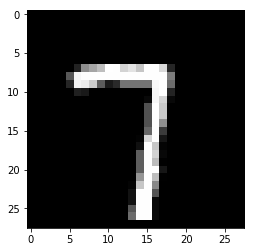

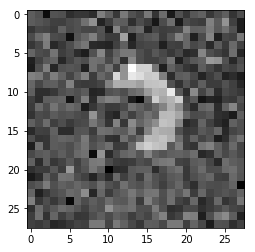

0 197.27463 180.54694 16.727692


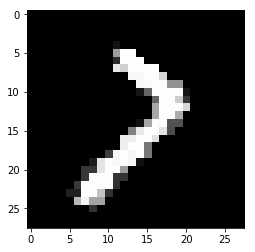

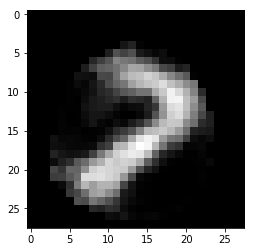

200 37.168655 35.029648 2.1390076


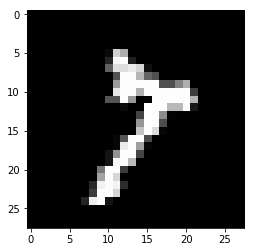

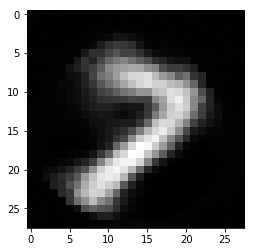

400 33.250183 31.561026 1.6891577


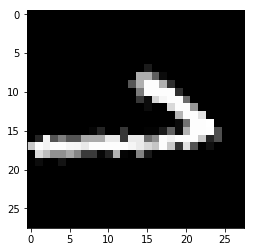

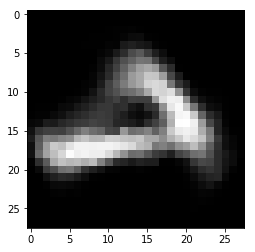

600 34.553326 32.768288 1.7850373


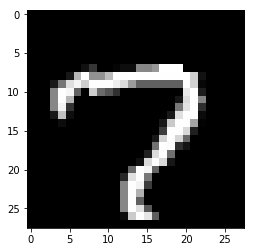

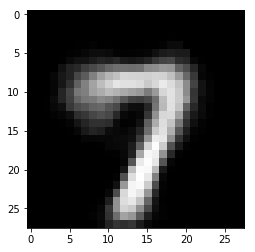

800 31.7654 29.964172 1.8012254


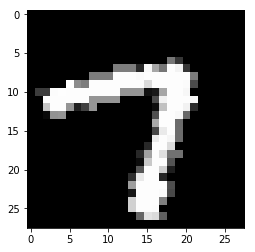

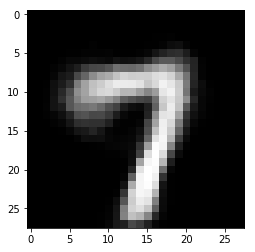

1000 35.536522 33.66333 1.8731966


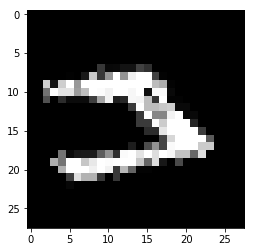

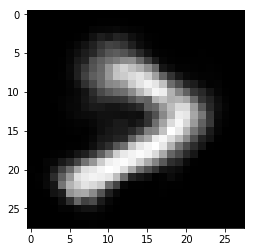

1200 31.969452 29.602852 2.3665996


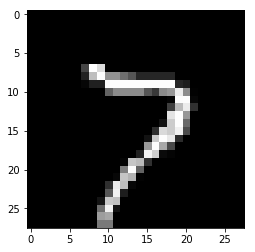

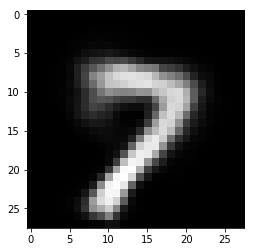

1400 29.749815 27.291847 2.457967


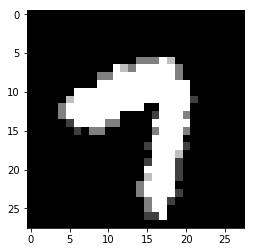

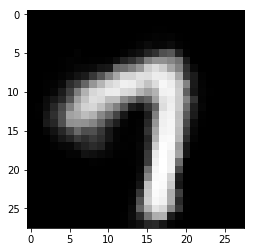

1600 29.437496 26.869446 2.5680509


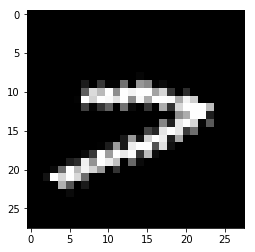

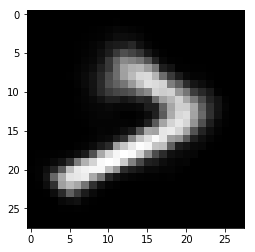

1800 32.35162 29.654968 2.69665


In [45]:
j = 0
for i in range(2000):
#     batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
#   for j in range(int(train_s.shape[0]/batch_size)):  # for batch size 
  if(j == int(train_s.shape[0]/batch_size)):
    j = 0
  batch = [np.reshape(b, [28,28]) for b in train_s[batch_size*j : batch_size*(j+1)] ]
  j += 1
#   print((batch[0].shape))
  sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})

  if not i % 200:
      ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
      plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
      plt.show()
      plt.imshow(d[0], cmap='gray')
      plt.show()
      print(i, ls, np.mean(i_ls), np.mean(d_ls))

In [0]:
n_i = np.zeros((20),dtype=float)
x = -5.0
for i in range(0,20):
  n_i[i] = x
  x += 0.5
  
z_distb = []
z_rand = np.zeros((20, n_latent), dtype=float)
# f, axarr = plt.subplots(4,10)
images = []
for j in range(n_latent):
  for k in range(n_latent):
    if(k == j):
      z_rand[:, k] = n_i
    else:
      z_rand[:, k] = np.random.normal(0,1)
#   print(z_rand)
#   z_distb.append(z_rand)
  randoms = [z_rand[i] for i in range(20)]
  imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
  images.append([np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))])
#   img_ct = 0
#   for img in images:
#       plt.figure(figsize=(1,1))
#       plt.axis('off')
#       axarr[j, img_ct] = plt.imshow(img, cmap='gray')
#       img_ct += 1

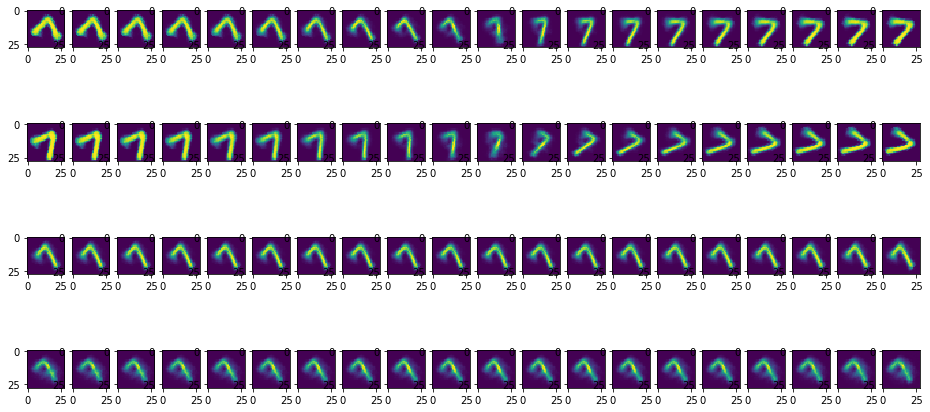

In [53]:
fig=plt.figure(figsize=(16, 8))
columns = 20
rows = 4
for i in range(0, columns*rows):
    img = images[int(i/20)][i%20]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
# plt.show()

Reference:
[link text](https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776)